In [56]:
import pandas as pd 
import numpy as np 
import os
from pydub import AudioSegment 
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, classification_report
import speaker_verification_toolkit.tools as svt
from tensorflow import keras
import plotly.graph_objects as go
from tensorflow.keras import layers  
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
%matplotlib inline

In [57]:
def convert_mp3_to_wav(mp3_path, wav_path):
    # Load MP3 file
    audio = AudioSegment.from_mp3(mp3_path)

    # Export as WAV
    audio.export(wav_path, format="wav")

In [58]:
def convert_mp3_folder_to_wav(mp3_folder, wav_folder):
    # Ensure the output folder exists
    os.makedirs(wav_folder, exist_ok=True)

    # Loop through all files in the MP3 folder
    for filename in os.listdir(mp3_folder):
        if filename.endswith(".mp3"):
            mp3_path = os.path.join(mp3_folder, filename)
            wav_filename = os.path.splitext(filename)[0] + ".wav"
            wav_path = os.path.join(wav_folder, wav_filename)

            # Convert MP3 to WAV
            convert_mp3_to_wav(mp3_path, wav_path)

            # Delete the original MP3 file
            os.remove(mp3_path)
            print(f"Converted {filename} to {wav_filename} and deleted {filename}")

def convert_mp3_to_wav(mp3_path, wav_path):
    # Load MP3 file
    audio = AudioSegment.from_mp3(mp3_path)

    # Export as WAV
    audio.export(wav_path, format="wav")

# Specify the paths to your MP3 folder and desired WAV folder
mp3_folder_path = "/Users/aditya/Desktop/Projects/SpeakerVerDataset/sound"
wav_folder_path = "/Users/aditya/Desktop/Projects/SpeakerVerDataset/sound"

# Convert all MP3 files in the specified folder to WAV and delete the original MP3 files
convert_mp3_folder_to_wav(mp3_folder_path, wav_folder_path)


# **TRY1 only with svt (rm background silence)**

In [59]:

def visualize_mfcc(data, sr, title):
    t = librosa.frames_to_time(np.arange(len(data[0])))

    fig = go.Figure()
    for i in range(len(data)):
        fig.add_trace(go.Scatter(x=t, y=data[i], mode='lines', name=f'MFCC {i+1}'))

    fig.update_layout(title_text=title, xaxis_title='Time (s)', yaxis_title='MFCC Value')
    fig.show()

# Example usage
data_adi, sr_adi = librosa.load('sound/adi.wav', sr=16000, mono=True)
data_leepi, sr_leepi = librosa.load('sound/leepi.wav', sr=16000, mono=True)

df_adi = librosa.feature.mfcc(y=data_adi, sr=sr_adi, n_mfcc=20)
df_leepi = librosa.feature.mfcc(y=data_leepi, sr=sr_leepi, n_mfcc=20)

visualize_mfcc(df_adi, sr_adi, title='MFCC - Adi')
visualize_mfcc(df_leepi, sr_leepi, title='MFCC - Leepi')

# mfccs = librosa.feature.mfcc(y=data_adi, sr=sr_adi, n_mfcc=20)


In [60]:
# data_adi = svt.rms_silence_filter(data_adi)
# data_leepi = svt.rms_silence_filter(data_leepi)

In [61]:
# data_adi = svt.extract_mfcc(data_adi,samplerate=16000, winlen=0.025, winstep=0.01)
# data_leepi = svt.extract_mfcc(data_leepi,samplerate=16000, winlen=0.025, winstep=0.01)

In [62]:
df_adi = pd.DataFrame(df_adi.T, columns=[f'MFCC_{i+1}' for i in range(df_adi.shape[0])])
df_leepi = pd.DataFrame(df_leepi.T, columns=[f'MFCC_{i+1}' for i in range(df_leepi.shape[0])])

In [63]:
df_adi["ID"] = 1
df_adi["Name"] = 'adi'
# df_adi.info()
df_adi

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20,ID,Name
0,-620.427856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,adi
1,-620.427856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,adi
2,-615.839844,4.625483,0.348513,-3.374226,-4.082054,-1.544896,2.217796,4.551626,4.113134,1.669970,...,-0.642530,0.652498,1.064308,0.424355,-0.292310,-0.018129,1.273115,2.405758,1,adi
3,-590.743103,32.963039,12.897312,-3.404069,-5.777104,4.094922,16.215643,21.519958,17.934628,9.436560,...,-4.761020,-3.340269,-0.698233,1.688150,2.573172,1.637395,-0.160175,-1.425383,1,adi
4,-572.743469,50.085182,15.994408,-6.251917,-8.679512,1.890170,15.892488,21.470547,14.855118,6.731004,...,-4.201941,-3.290267,1.780818,3.824395,4.257024,5.269965,2.237642,-3.346197,1,adi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,-602.755615,19.853926,10.688784,5.304411,3.063208,2.851258,5.902261,8.500531,6.369061,2.693069,...,-4.165745,-2.880628,-0.554298,-1.734800,-3.221231,-1.607621,-0.697854,-2.306244,1,adi
62,-601.256592,21.736244,11.852829,5.936018,4.081273,4.003017,5.523246,6.359208,4.392262,2.066185,...,-3.311063,-1.358334,1.648793,1.014364,-1.040835,-1.157849,-1.424646,-3.046650,1,adi
63,-596.467346,27.775208,15.406698,6.377551,3.422666,3.754492,4.019676,2.686006,1.214379,1.122187,...,-0.880922,1.626587,4.154996,4.358618,2.223227,-0.818683,-2.589141,-2.490477,1,adi
64,-595.625732,25.942039,9.807191,1.856424,0.816282,0.222033,1.021924,3.580749,4.016704,2.351108,...,-0.857927,0.354295,3.380194,2.884266,-0.615227,-1.132759,0.971530,0.146124,1,adi


In [64]:
df_leepi

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20
0,-502.035614,2.905253,1.963773,1.301727,0.913439,0.246622,-0.739524,-1.360126,-1.199851,-0.776576,-0.824423,-1.276025,-1.481067,-1.278728,-1.234027,-1.677391,-2.070889,-1.725843,-0.794727,-0.027027
1,-414.264526,71.109604,2.029063,-8.214191,-0.120411,3.563288,-12.525026,-27.690674,-5.231861,10.213138,-12.442171,-14.441429,-4.570152,-5.878261,-2.948921,-3.607251,-11.026205,-9.164663,-3.569996,-8.265687
2,-258.170593,78.042862,-0.929826,31.957464,-33.134605,18.491444,-1.509282,-9.712257,-21.427519,14.167688,-19.093115,2.201162,5.531885,-6.760185,1.882387,-13.280704,3.412517,-7.574950,4.123249,-9.316028
3,-131.804703,80.380890,1.860601,40.768791,-55.787731,17.354906,10.894516,-3.602545,-36.979156,20.749710,-20.915104,10.577521,0.534924,-7.169306,-6.213170,-9.857544,-1.434024,-2.365818,0.182220,-7.403473
4,-57.464241,79.340012,6.347599,43.641228,-63.714272,19.482281,10.474520,-8.579994,-38.706741,17.998672,-24.493992,9.632309,-2.155790,-8.621922,-3.563176,-7.227435,-3.021622,-0.904399,-3.934055,-11.508080
5,-38.154964,87.393921,22.734776,51.939034,-64.252930,18.789970,2.712249,-18.194330,-42.810646,10.594526,-29.639206,6.809362,-0.901374,-6.673831,-8.130040,-12.073734,-7.738270,-2.333277,-11.588018,-16.926228
6,-94.312347,97.260605,39.488785,54.038490,-64.987335,12.382006,-2.525091,-28.233332,-46.242920,12.308422,-27.794868,1.691661,-0.868229,-2.187702,-9.630842,-16.277777,-11.713226,-8.091679,-12.814789,-18.883575
7,-193.961151,89.905396,51.031757,48.192783,-62.130852,-3.986918,-7.092801,-32.493431,-38.377998,17.593082,-33.021729,4.119259,-8.018394,-0.328548,2.432867,-9.684587,-14.354086,-18.927549,-6.756395,-18.084236
8,-185.438110,64.445419,36.647903,40.665779,-74.463333,-12.611385,-8.584949,-24.732018,-41.016445,18.615789,-25.270819,4.455227,-6.966104,1.748465,0.595417,-10.000097,-12.596063,-13.956374,-8.385889,-18.153093
9,-164.702286,61.553349,31.383785,40.950661,-77.519196,-13.636288,-6.778161,-17.465076,-44.831856,13.786807,-27.024979,6.014590,-5.912170,2.392918,-3.853448,-10.592936,-10.681543,-11.237587,-8.527273,-22.203970


In [65]:
df_leepi["ID"] = 2
df_leepi["Name"] = 'leepi'
df_leepi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MFCC_1   34 non-null     float32
 1   MFCC_2   34 non-null     float32
 2   MFCC_3   34 non-null     float32
 3   MFCC_4   34 non-null     float32
 4   MFCC_5   34 non-null     float32
 5   MFCC_6   34 non-null     float32
 6   MFCC_7   34 non-null     float32
 7   MFCC_8   34 non-null     float32
 8   MFCC_9   34 non-null     float32
 9   MFCC_10  34 non-null     float32
 10  MFCC_11  34 non-null     float32
 11  MFCC_12  34 non-null     float32
 12  MFCC_13  34 non-null     float32
 13  MFCC_14  34 non-null     float32
 14  MFCC_15  34 non-null     float32
 15  MFCC_16  34 non-null     float32
 16  MFCC_17  34 non-null     float32
 17  MFCC_18  34 non-null     float32
 18  MFCC_19  34 non-null     float32
 19  MFCC_20  34 non-null     float32
 20  ID       34 non-null     int64  
 21  Name     34 non-nu

In [66]:
df = pd.concat([df_adi,df_leepi],ignore_index=True)

In [67]:
df.Name = (df.Name == 'adi').astype(int)

In [68]:
df.Name.unique()

array([1, 0])

In [69]:
df

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20,ID,Name
0,-620.427856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
1,-620.427856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
2,-615.839844,4.625483,0.348513,-3.374226,-4.082054,-1.544896,2.217796,4.551626,4.113134,1.669970,...,-0.642530,0.652498,1.064308,0.424355,-0.292310,-0.018129,1.273115,2.405758,1,1
3,-590.743103,32.963039,12.897312,-3.404069,-5.777104,4.094922,16.215643,21.519958,17.934628,9.436560,...,-4.761020,-3.340269,-0.698233,1.688150,2.573172,1.637395,-0.160175,-1.425383,1,1
4,-572.743469,50.085182,15.994408,-6.251917,-8.679512,1.890170,15.892488,21.470547,14.855118,6.731004,...,-4.201941,-3.290267,1.780818,3.824395,4.257024,5.269965,2.237642,-3.346197,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-283.789398,176.752914,54.721577,21.452549,12.646338,31.017380,0.712162,-0.220781,-19.929556,-4.638701,...,-8.507656,-10.983441,-20.557030,-13.505011,-4.647154,-6.236250,-3.420759,-2.779260,2,0
96,-304.555267,184.341309,62.929420,8.925140,11.767843,38.295628,7.321642,-5.746310,-16.458263,-10.417665,...,-8.727818,-17.893078,-24.994362,-6.931791,2.479356,3.072721,-4.516051,-11.766681,2,0
97,-305.972046,187.542938,43.189259,-16.189072,12.496913,49.604256,19.673569,-8.016241,-12.699842,-12.025949,...,-10.396801,-15.995037,-23.030807,-7.462792,5.468378,1.441688,-8.017524,-16.951355,2,0
98,-260.117279,156.059555,29.744692,0.110917,17.011700,36.687073,29.036449,1.515908,-10.963293,-9.529129,...,-7.747791,-16.539207,-14.399851,-6.286277,1.519631,-2.940766,-9.576100,-14.120507,2,0


In [70]:
df = df.sample(frac=1).reset_index(drop=True)

In [71]:
df

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20,ID,Name
0,-502.035614,2.905253,1.963773,1.301727,0.913439,0.246622,-0.739524,-1.360126,-1.199851,-0.776576,...,-1.481067,-1.278728,-1.234027,-1.677391,-2.070889,-1.725843,-0.794727,-0.027027,2,0
1,-229.292892,150.024857,29.306473,17.740704,-6.268222,-9.117738,-30.315514,-20.193443,-32.365597,9.268724,...,0.329736,-19.788626,-9.618647,-12.270036,-7.737008,-8.555524,-16.468664,-5.693089,2,0
2,-256.782166,172.763977,22.654240,20.172850,16.723858,29.421227,7.027864,2.814477,-22.856781,-4.351128,...,-10.539415,1.821769,-14.189932,-19.659939,-5.537936,-11.101532,-8.376970,-0.803344,2,0
3,-147.013794,89.805382,17.450331,64.361176,-54.752842,7.260159,-17.825798,-8.808911,-30.665031,-9.738279,...,-14.216541,-9.101933,-1.359178,-4.882395,-15.875817,-5.798371,-7.170350,-14.380083,2,0
4,-594.092834,31.111794,18.435007,8.548588,4.306124,3.894023,5.537076,6.384974,3.249824,-2.739791,...,-4.980125,-1.209232,1.077653,-0.212129,-2.608950,-1.768518,1.300345,1.753782,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-260.117279,156.059555,29.744692,0.110917,17.011700,36.687073,29.036449,1.515908,-10.963293,-9.529129,...,-7.747791,-16.539207,-14.399851,-6.286277,1.519631,-2.940766,-9.576100,-14.120507,2,0
96,-603.873779,20.220890,13.213326,6.416251,1.527296,-0.306683,1.864267,5.945656,8.294937,7.885519,...,-2.687272,-4.475923,-3.911075,-3.106828,-2.324365,-1.055909,-0.977303,-3.250466,1,1
97,-615.839844,4.625483,0.348513,-3.374226,-4.082054,-1.544896,2.217796,4.551626,4.113134,1.669970,...,-0.642530,0.652498,1.064308,0.424355,-0.292310,-0.018129,1.273115,2.405758,1,1
98,-601.086304,23.364185,14.344824,5.972264,1.849773,2.519876,6.253351,9.382969,8.551504,4.078167,...,-2.648419,-1.019667,0.441289,0.228625,-1.247649,-1.722108,-0.369596,0.853355,1,1


In [72]:
train ,valid, test = np.split(df, [int(0.6*len(df)),int(0.8*len(df))])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



In [73]:
def scale_dataset(dataframe, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [74]:
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [81]:
train.dtype

dtype('float64')

In [ ]:
gmm = GaussianMixture(n_components = 14, max_iter = 500, covariance_type='diag',n_init = 3)

gmm.fit(X_train)


GaussianMixture(covariance_type='diag', max_iter=500, n_components=14, n_init=3)

In [ ]:
y_pred = gmm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.0
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      10.0
           1       0.00      0.00      0.00      10.0
           4       0.00      0.00      0.00       0.0

    accuracy                           0.00      20.0
   macro avg       0.00      0.00      0.00      20.0
weighted avg       0.00      0.00      0.00      20.0



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [ ]:
# def train_dual_conv_model(X_train, y_train, num_filters, kernel_size, pool_size, num_nodes, dropout_prob, lr, batch_size, epochs):
#   nn_model = keras.Sequential([
#     layers.Conv1D(num_filters, kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)),
#     layers.MaxPooling1D(pool_size),
#     layers.Flatten(),
#     keras.layers.Dense(num_nodes, activation='relu', input_shape=(21,1)),
#     keras.layers.Dropout(dropout_prob),
#     keras.layers.Dense(num_nodes, activation='relu'),
#     keras.layers.Dropout(dropout_prob),
#     keras.layers.Dense(1, activation='sigmoid')
#   ])

#   nn_model.compile(optimizer=keras.optimizers.legacy.Adam(lr), loss='binary_crossentropy',
#                   metrics=['accuracy'])
#   history = nn_model.fit(
#     X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
#   )

#   return nn_model, history



# def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
#   nn_model = keras.Sequential([
#       keras.layers.Dense(num_nodes, activation='relu', input_shape=(21,)),
#       keras.layers.Dropout(dropout_prob),
#       keras.layers.Dense(num_nodes, activation='relu'),
#       keras.layers.Dropout(dropout_prob),
#       keras.layers.Dense(1, activation='sigmoid')
#   ])

#   nn_model.compile(optimizer=keras.optimizers.legacy.Adam(lr), loss='binary_crossentropy',
#                   metrics=['accuracy'])
#   history = nn_model.fit(
#     X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
#   )

#   return nn_model, history



def train_lstm_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
    # Add a new axis to the input data to make it 3D
    X_train = X_train[:, :, np.newaxis]

    lstm_model = keras.Sequential([
        layers.LSTM(num_nodes, activation='relu', input_shape=(X_train.shape[1], 1)),
        keras.layers.Dropout(dropout_prob),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(optimizer=keras.optimizers.legacy.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

    return lstm_model, history


In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

16 nodes, dropout 0, lr 0.01, batch size 32


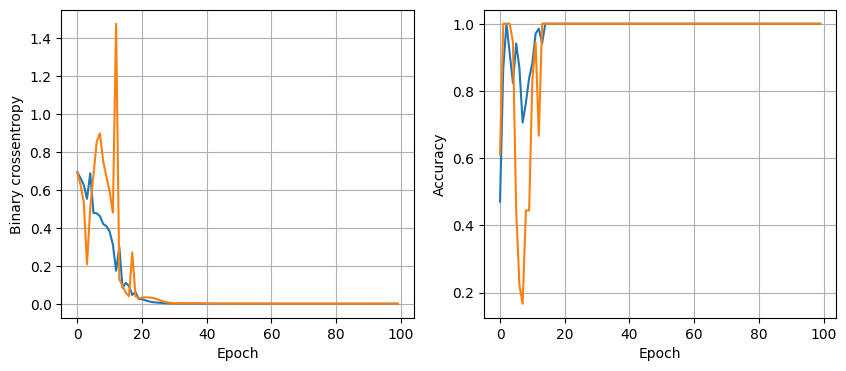

1/1 [==============================] - 0s 23ms/step - loss: 0.1149 - accuracy: 0.9500
16 nodes, dropout 0, lr 0.01, batch size 64


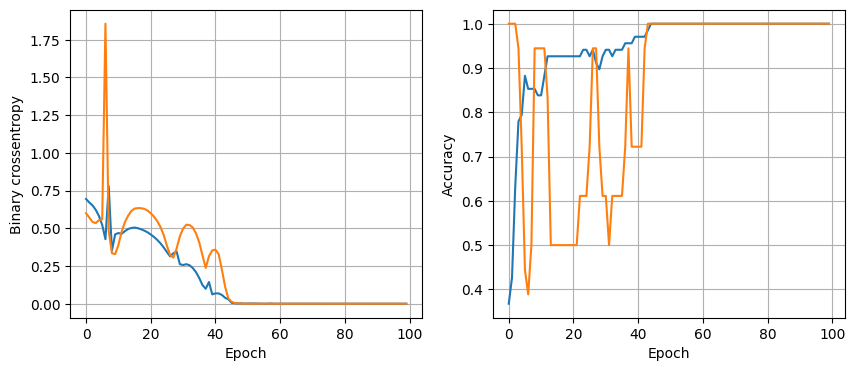

1/1 [==============================] - 0s 13ms/step - loss: 9.8546e-04 - accuracy: 1.0000
16 nodes, dropout 0, lr 0.01, batch size 128


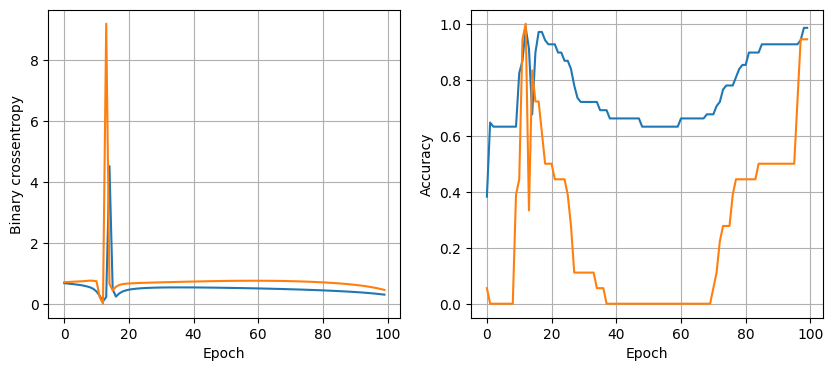

1/1 [==============================] - 0s 17ms/step - loss: 0.2888 - accuracy: 0.9500
16 nodes, dropout 0, lr 0.005, batch size 32


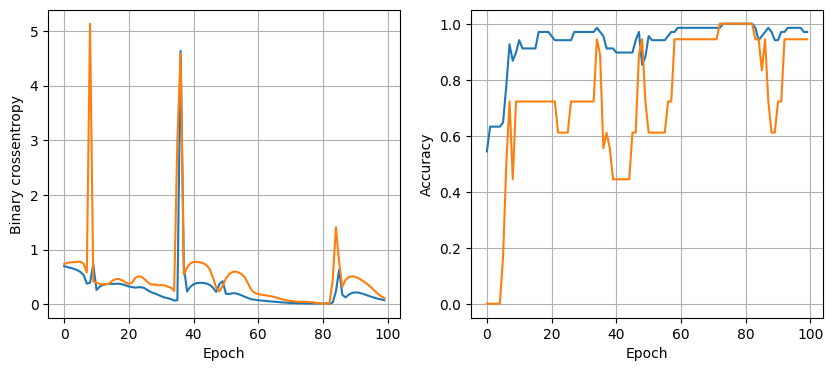

1/1 [==============================] - 0s 14ms/step - loss: 0.0748 - accuracy: 0.9500
16 nodes, dropout 0, lr 0.005, batch size 64


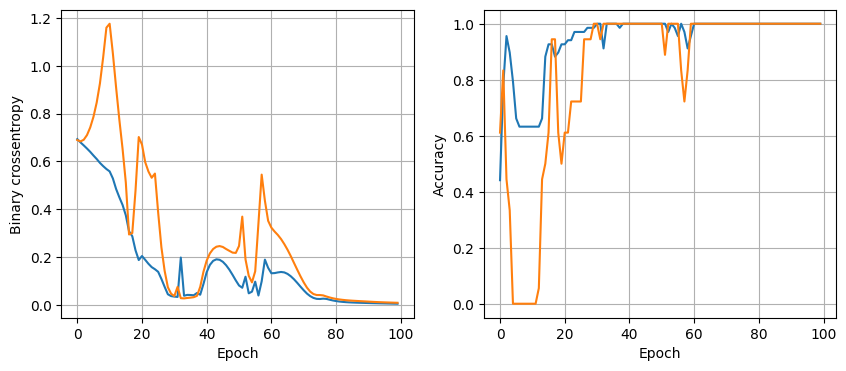

1/1 [==============================] - 0s 17ms/step - loss: 0.0040 - accuracy: 1.0000
16 nodes, dropout 0, lr 0.005, batch size 128


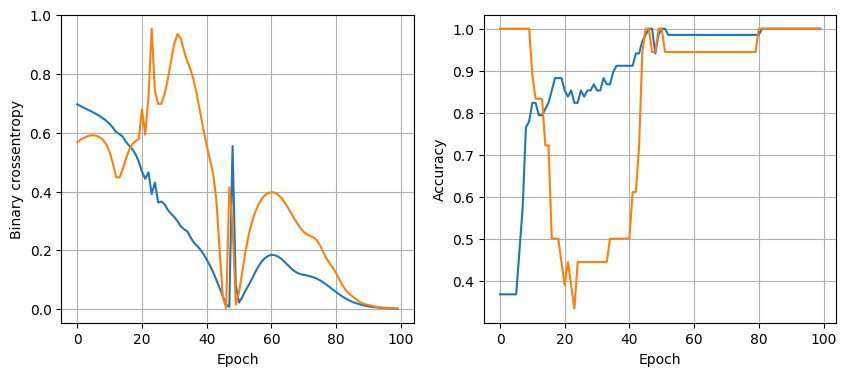

1/1 [==============================] - 0s 18ms/step - loss: 0.0027 - accuracy: 1.0000
16 nodes, dropout 0, lr 0.001, batch size 32


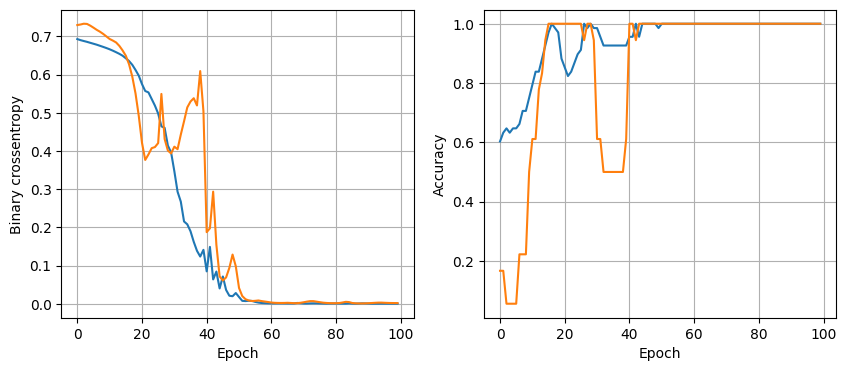

1/1 [==============================] - 0s 20ms/step - loss: 1.1870 - accuracy: 0.9500
16 nodes, dropout 0, lr 0.001, batch size 64


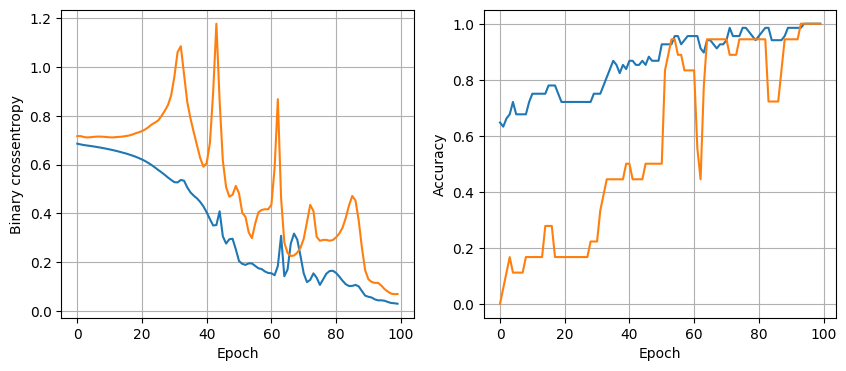

1/1 [==============================] - 0s 25ms/step - loss: 0.0476 - accuracy: 0.9500
16 nodes, dropout 0, lr 0.001, batch size 128


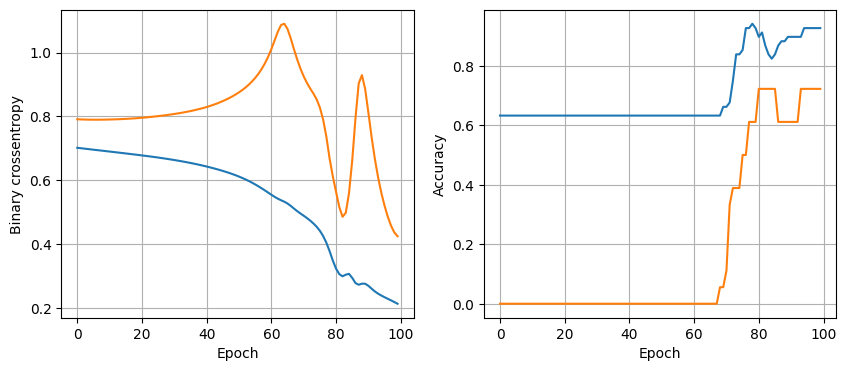

1/1 [==============================] - 0s 23ms/step - loss: 0.1930 - accuracy: 1.0000
16 nodes, dropout 0.2, lr 0.01, batch size 32


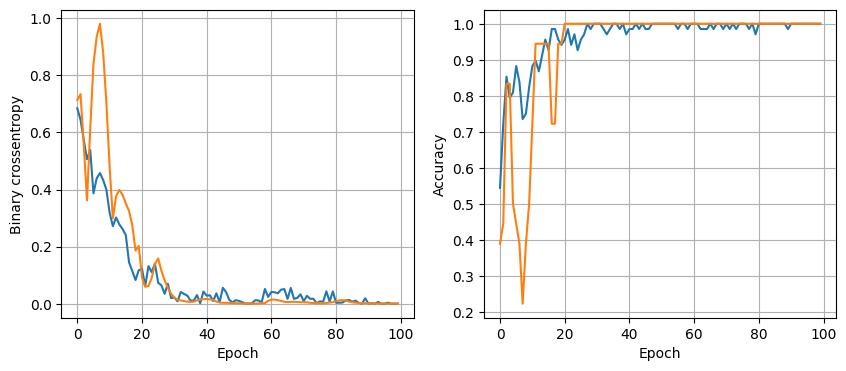

1/1 [==============================] - 0s 22ms/step - loss: 1.5502e-04 - accuracy: 1.0000
16 nodes, dropout 0.2, lr 0.01, batch size 64


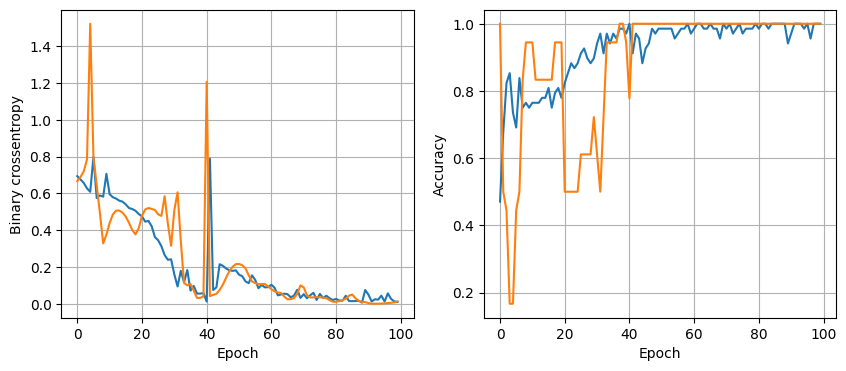

1/1 [==============================] - 0s 14ms/step - loss: 0.0106 - accuracy: 1.0000
16 nodes, dropout 0.2, lr 0.01, batch size 128


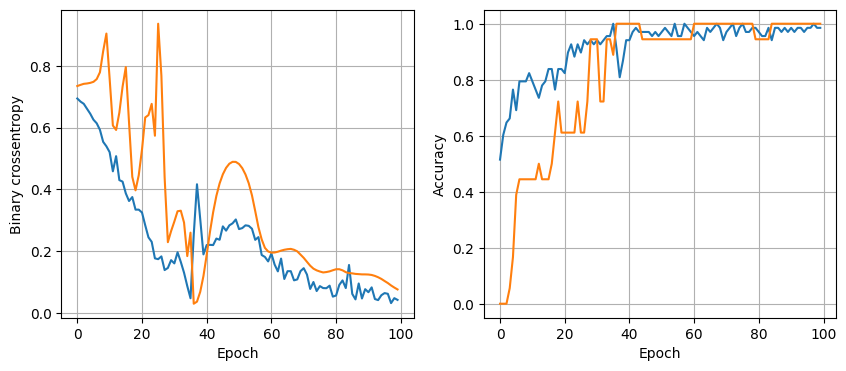

1/1 [==============================] - 0s 24ms/step - loss: 0.0193 - accuracy: 1.0000
16 nodes, dropout 0.2, lr 0.005, batch size 32


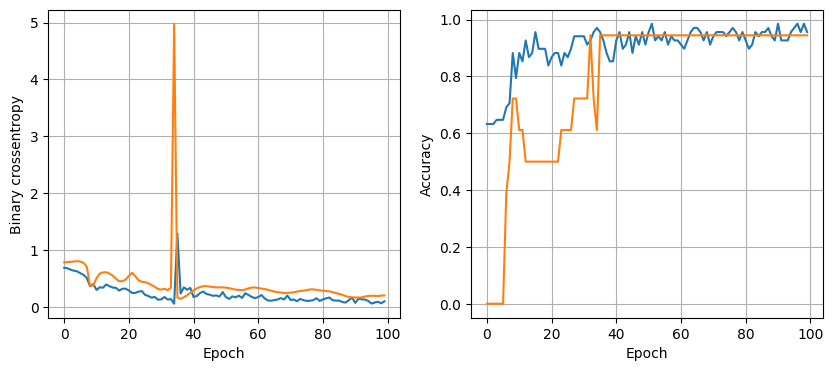

1/1 [==============================] - 0s 20ms/step - loss: 0.0477 - accuracy: 1.0000
16 nodes, dropout 0.2, lr 0.005, batch size 64


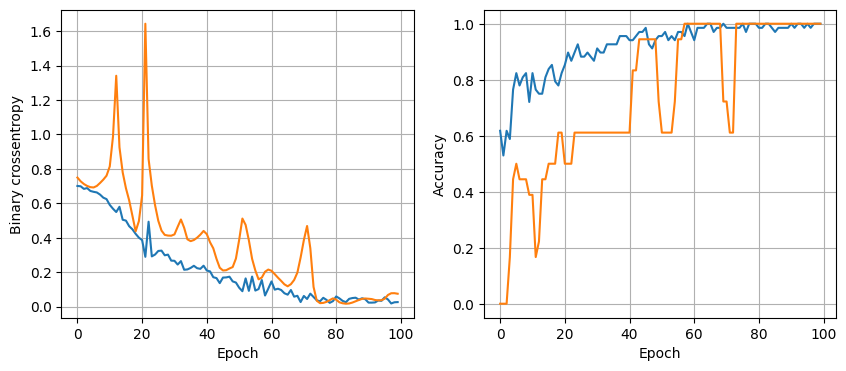

1/1 [==============================] - 0s 43ms/step - loss: 0.0624 - accuracy: 1.0000
16 nodes, dropout 0.2, lr 0.005, batch size 128


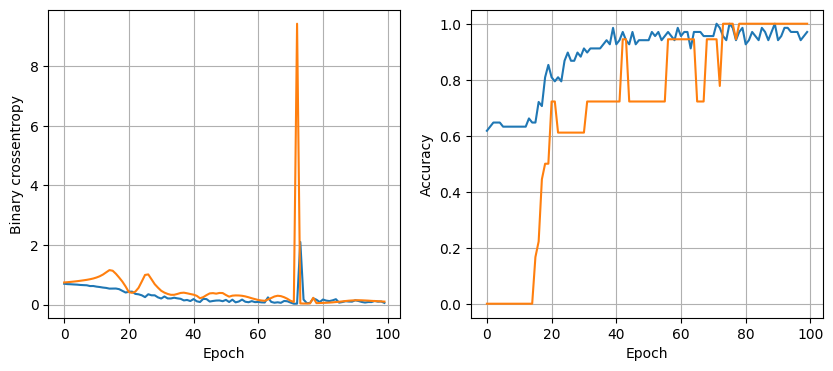

1/1 [==============================] - 0s 68ms/step - loss: 0.0218 - accuracy: 1.0000
16 nodes, dropout 0.2, lr 0.001, batch size 32


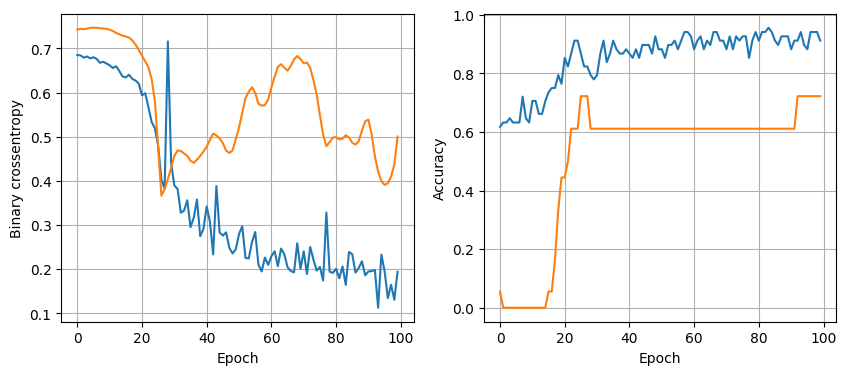

1/1 [==============================] - 0s 15ms/step - loss: 0.1085 - accuracy: 1.0000
16 nodes, dropout 0.2, lr 0.001, batch size 64


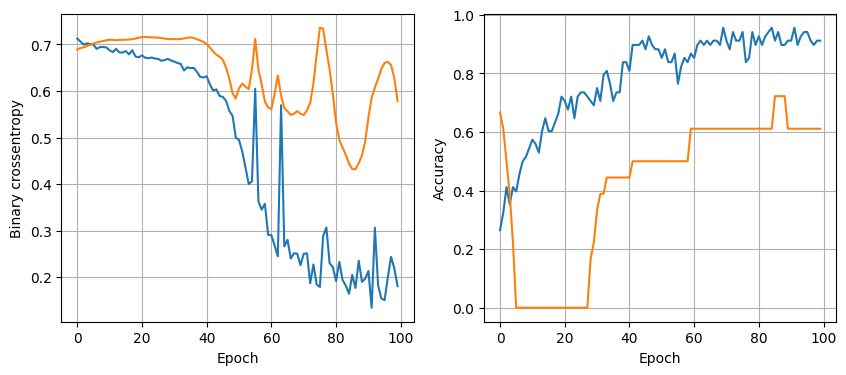

1/1 [==============================] - 0s 22ms/step - loss: 0.1671 - accuracy: 0.9000
16 nodes, dropout 0.2, lr 0.001, batch size 128


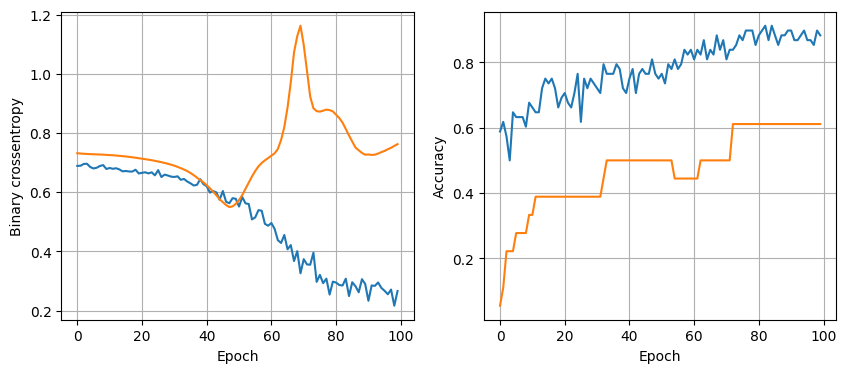

1/1 [==============================] - 0s 61ms/step - loss: 0.2211 - accuracy: 0.9000
32 nodes, dropout 0, lr 0.01, batch size 32


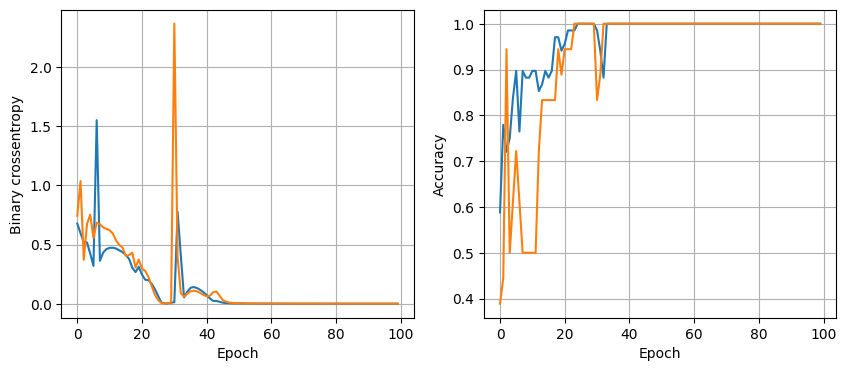

1/1 [==============================] - 0s 17ms/step - loss: 0.0223 - accuracy: 1.0000
32 nodes, dropout 0, lr 0.01, batch size 64


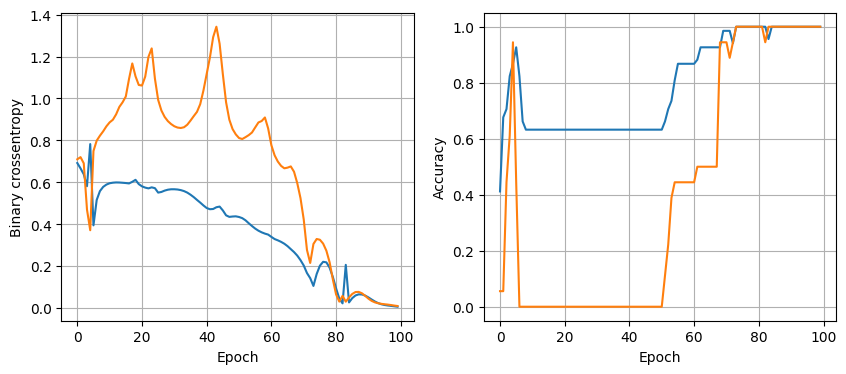

1/1 [==============================] - 0s 19ms/step - loss: 0.0015 - accuracy: 1.0000
32 nodes, dropout 0, lr 0.01, batch size 128


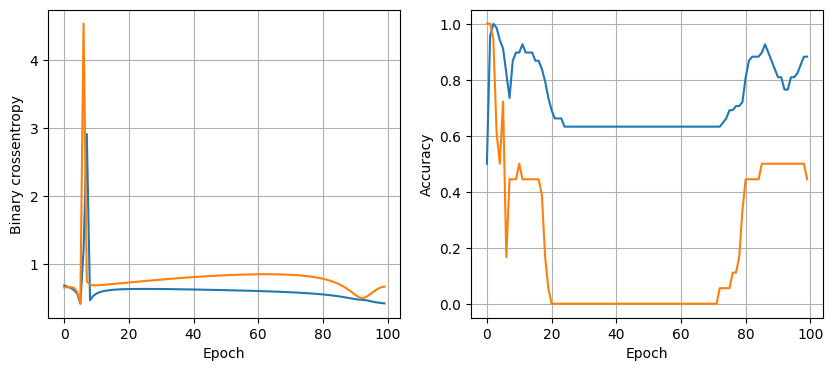

1/1 [==============================] - 0s 28ms/step - loss: 0.3744 - accuracy: 0.9000
32 nodes, dropout 0, lr 0.005, batch size 32


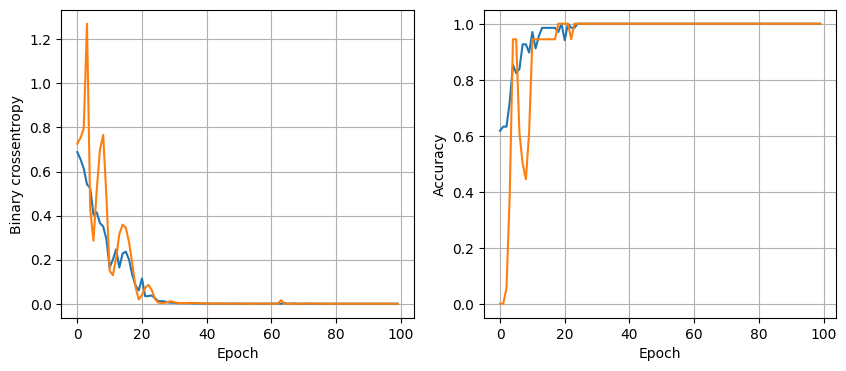

1/1 [==============================] - 0s 14ms/step - loss: 9.1603e-05 - accuracy: 1.0000
32 nodes, dropout 0, lr 0.005, batch size 64


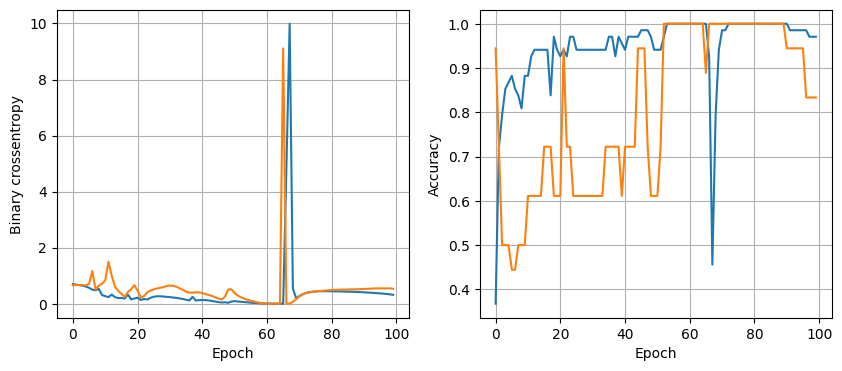

1/1 [==============================] - 0s 25ms/step - loss: 0.2577 - accuracy: 0.9500
32 nodes, dropout 0, lr 0.005, batch size 128


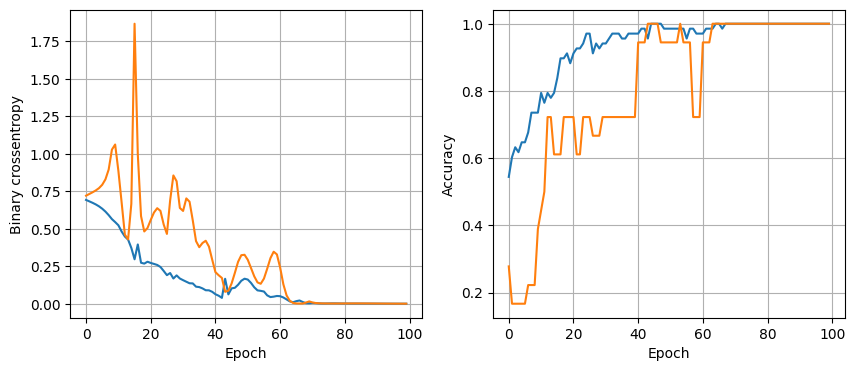

1/1 [==============================] - 0s 26ms/step - loss: 2.8257e-04 - accuracy: 1.0000
32 nodes, dropout 0, lr 0.001, batch size 32


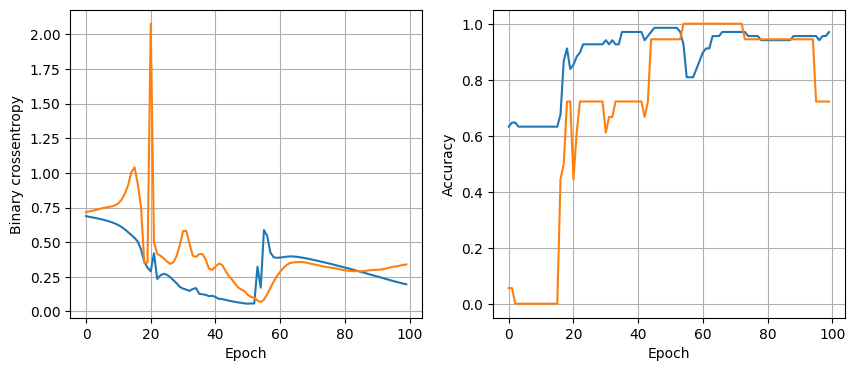

1/1 [==============================] - 0s 26ms/step - loss: 0.1980 - accuracy: 0.9500
32 nodes, dropout 0, lr 0.001, batch size 64


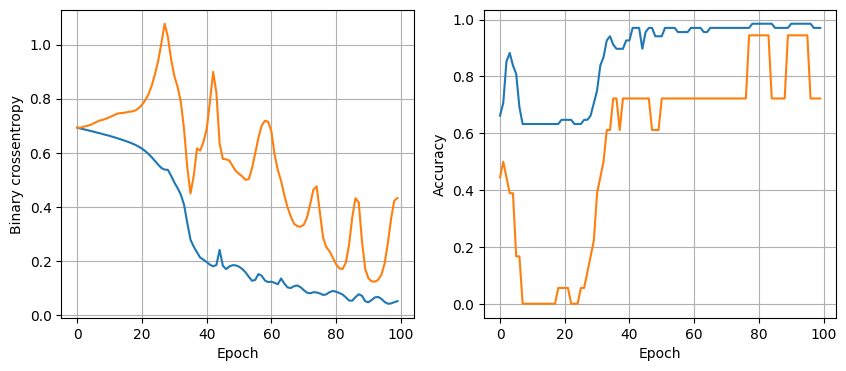

1/1 [==============================] - 0s 50ms/step - loss: 0.0709 - accuracy: 0.9500
32 nodes, dropout 0, lr 0.001, batch size 128


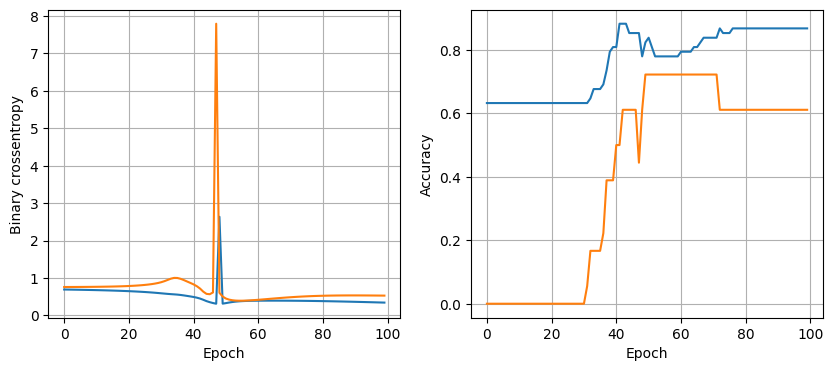

1/1 [==============================] - 0s 16ms/step - loss: 0.3498 - accuracy: 0.9000
32 nodes, dropout 0.2, lr 0.01, batch size 32


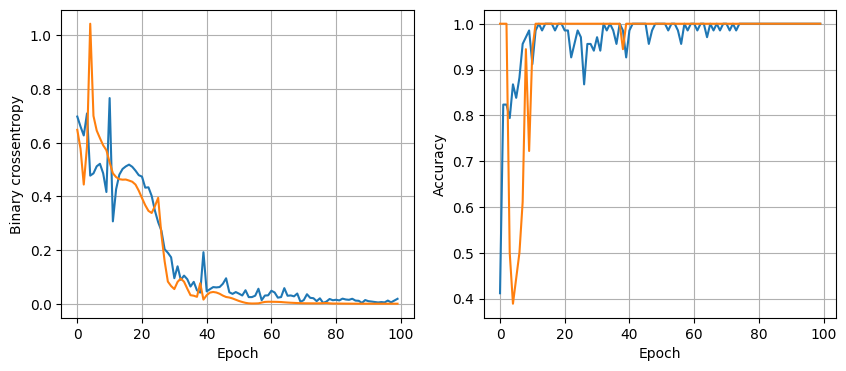

1/1 [==============================] - 0s 15ms/step - loss: 1.3273e-04 - accuracy: 1.0000
32 nodes, dropout 0.2, lr 0.01, batch size 64


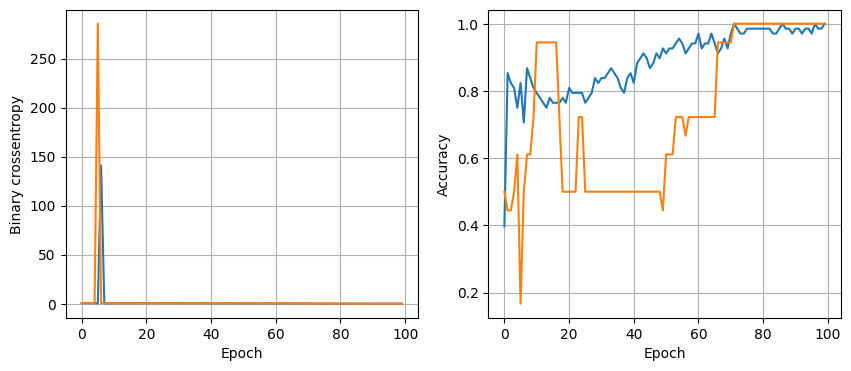

1/1 [==============================] - 0s 53ms/step - loss: 0.0180 - accuracy: 1.0000
32 nodes, dropout 0.2, lr 0.01, batch size 128


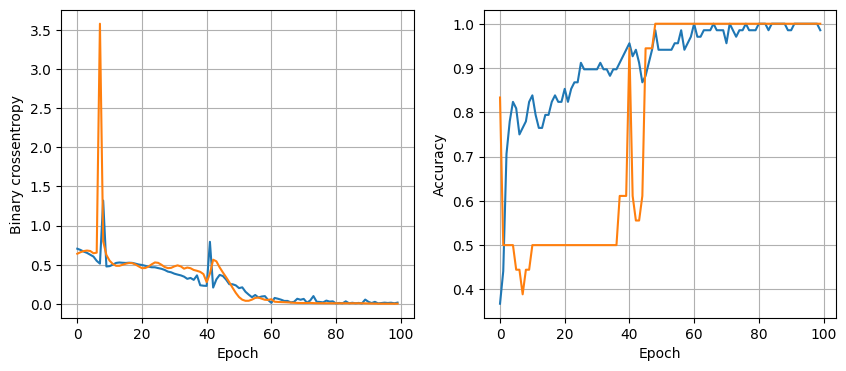

1/1 [==============================] - 0s 25ms/step - loss: 0.0168 - accuracy: 1.0000
32 nodes, dropout 0.2, lr 0.005, batch size 32


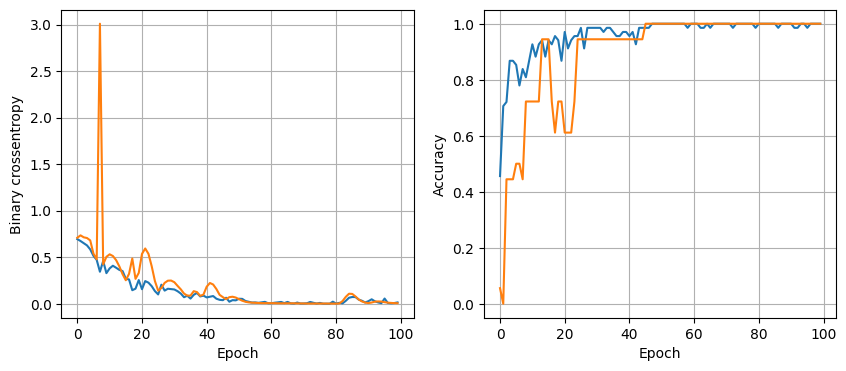

1/1 [==============================] - 0s 27ms/step - loss: 0.0014 - accuracy: 1.0000
32 nodes, dropout 0.2, lr 0.005, batch size 64


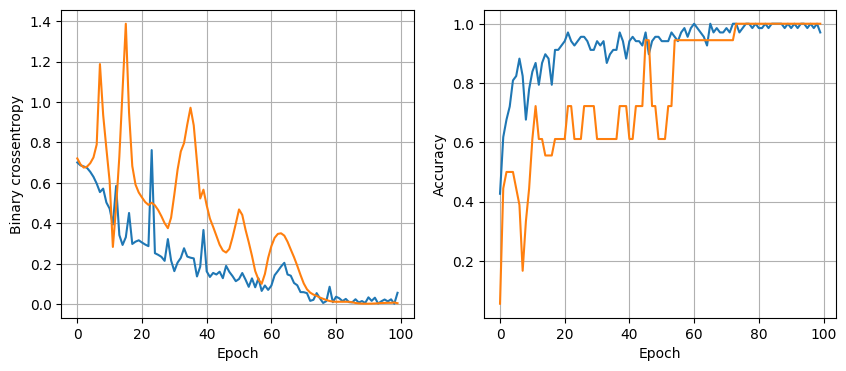

1/1 [==============================] - 0s 24ms/step - loss: 0.0017 - accuracy: 1.0000
32 nodes, dropout 0.2, lr 0.005, batch size 128


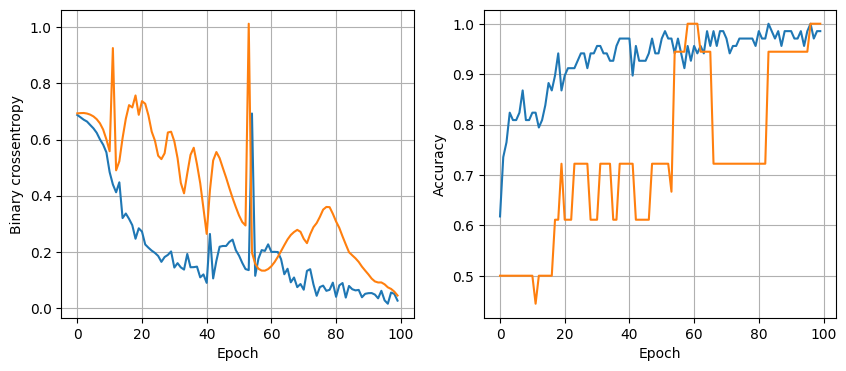

1/1 [==============================] - 0s 20ms/step - loss: 0.0060 - accuracy: 1.0000
32 nodes, dropout 0.2, lr 0.001, batch size 32


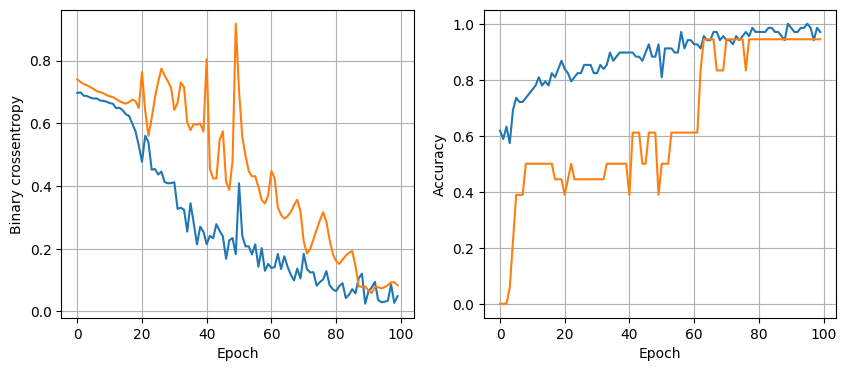

1/1 [==============================] - 0s 14ms/step - loss: 0.0880 - accuracy: 0.9500
32 nodes, dropout 0.2, lr 0.001, batch size 64


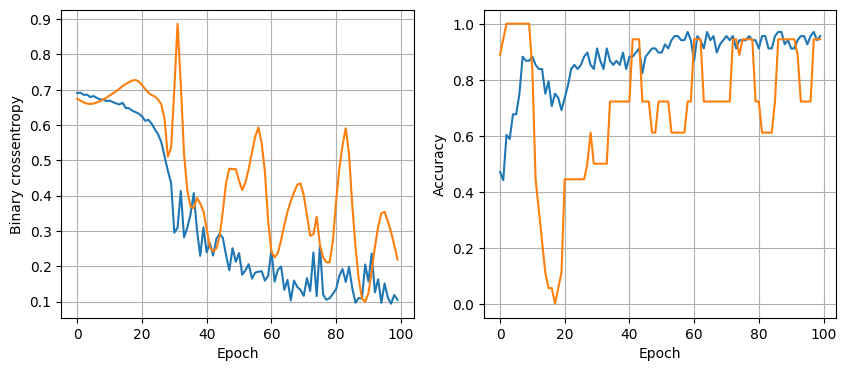

1/1 [==============================] - 0s 19ms/step - loss: 0.0934 - accuracy: 1.0000
32 nodes, dropout 0.2, lr 0.001, batch size 128


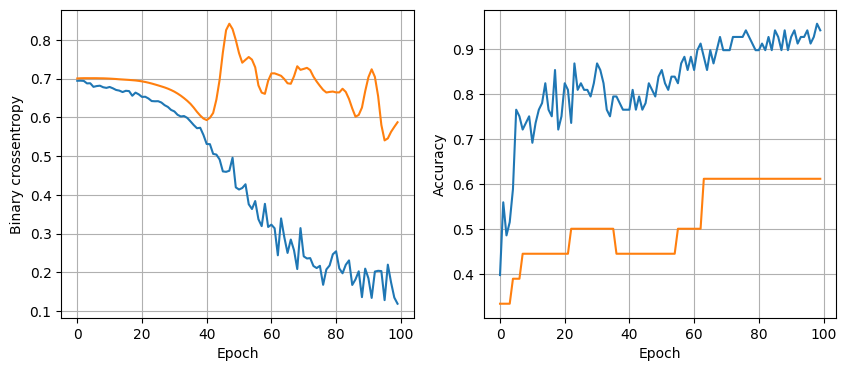

1/1 [==============================] - 0s 24ms/step - loss: 0.1088 - accuracy: 0.9500
64 nodes, dropout 0, lr 0.01, batch size 32


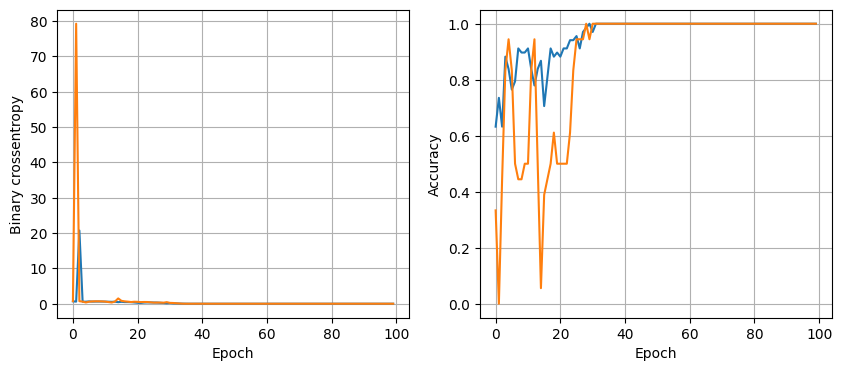

1/1 [==============================] - 0s 19ms/step - loss: 0.1587 - accuracy: 0.9500
64 nodes, dropout 0, lr 0.01, batch size 64


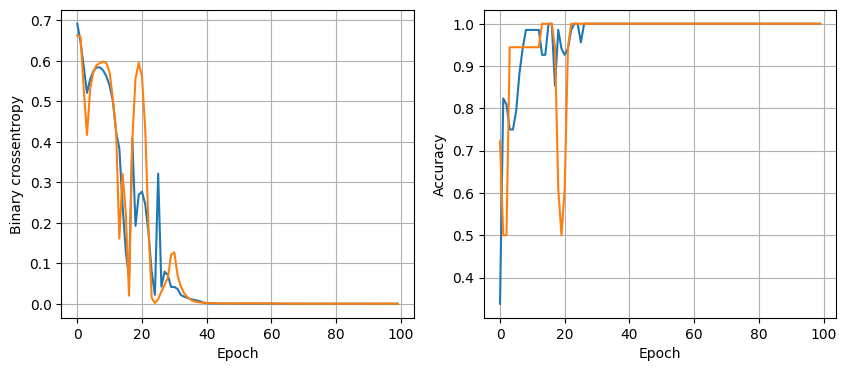

1/1 [==============================] - 0s 25ms/step - loss: 2.6600e-04 - accuracy: 1.0000
64 nodes, dropout 0, lr 0.01, batch size 128


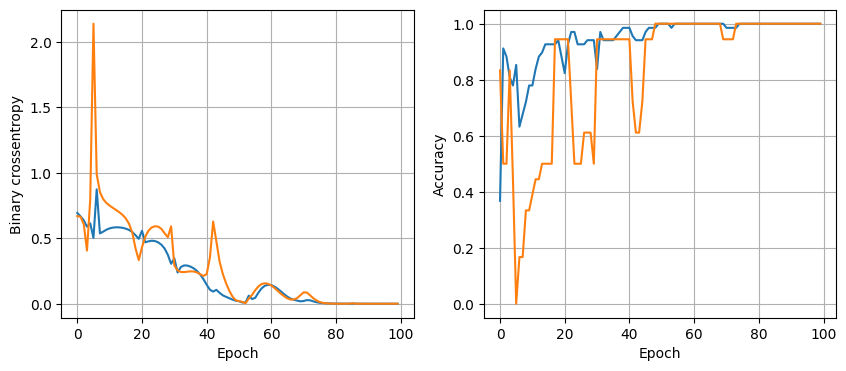

1/1 [==============================] - 0s 24ms/step - loss: 1.0612e-04 - accuracy: 1.0000
64 nodes, dropout 0, lr 0.005, batch size 32


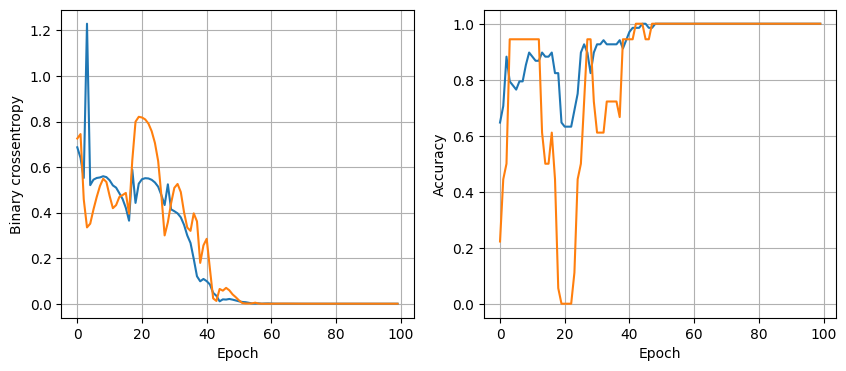

1/1 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 1.0000
64 nodes, dropout 0, lr 0.005, batch size 64


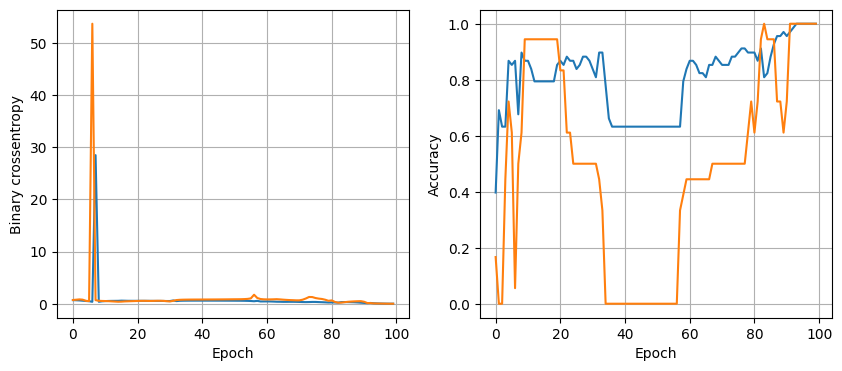

1/1 [==============================] - 0s 18ms/step - loss: 0.0014 - accuracy: 1.0000
64 nodes, dropout 0, lr 0.005, batch size 128


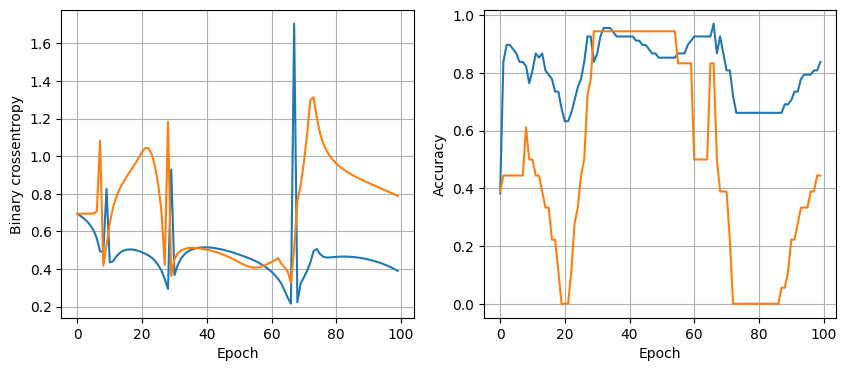

1/1 [==============================] - 0s 17ms/step - loss: 0.3544 - accuracy: 0.8000
64 nodes, dropout 0, lr 0.001, batch size 32


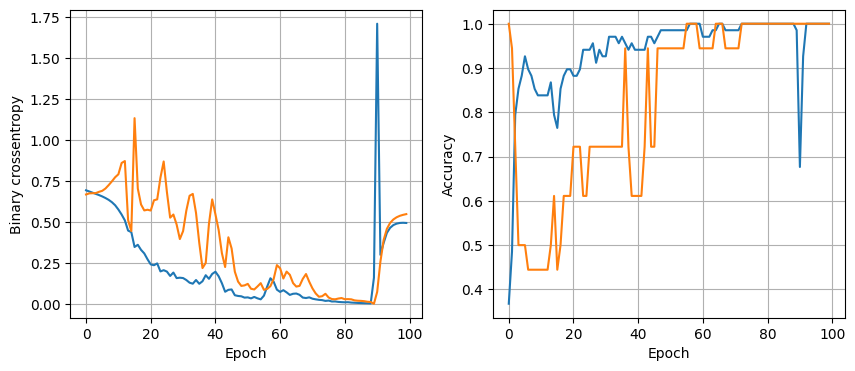

1/1 [==============================] - 0s 27ms/step - loss: 0.4933 - accuracy: 1.0000
64 nodes, dropout 0, lr 0.001, batch size 64


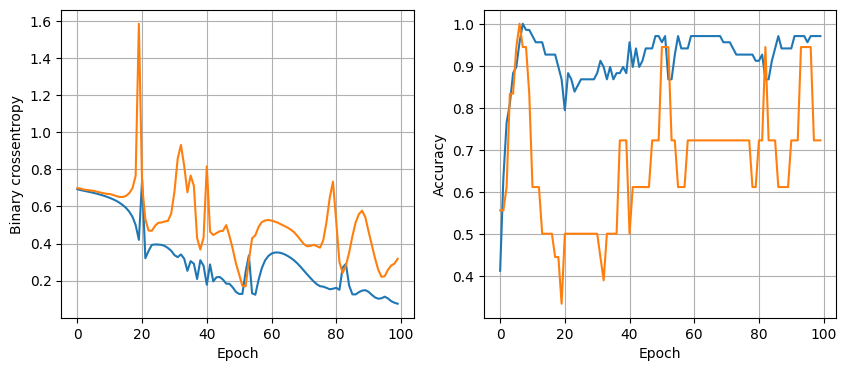

1/1 [==============================] - 0s 32ms/step - loss: 0.0541 - accuracy: 1.0000
64 nodes, dropout 0, lr 0.001, batch size 128


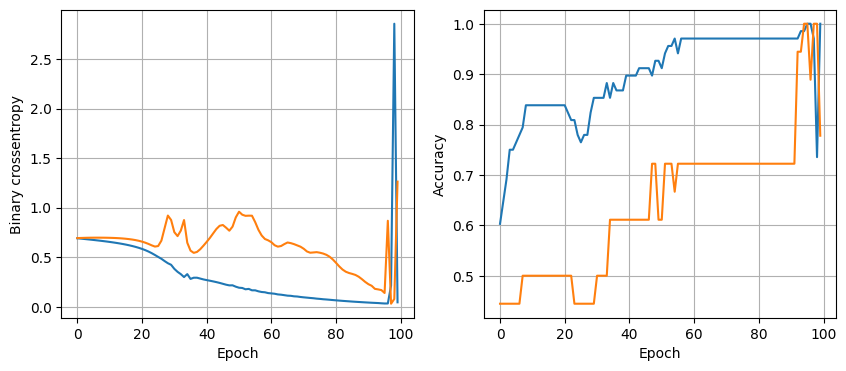

1/1 [==============================] - 0s 16ms/step - loss: 0.5519 - accuracy: 0.9500
64 nodes, dropout 0.2, lr 0.01, batch size 32


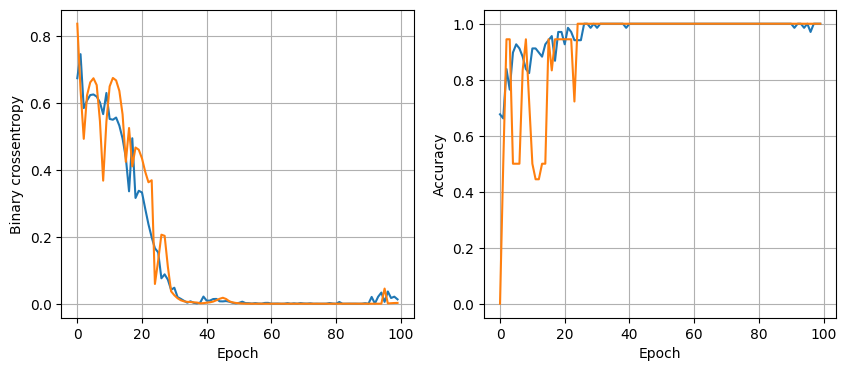

1/1 [==============================] - 0s 18ms/step - loss: 0.0039 - accuracy: 1.0000
64 nodes, dropout 0.2, lr 0.01, batch size 64


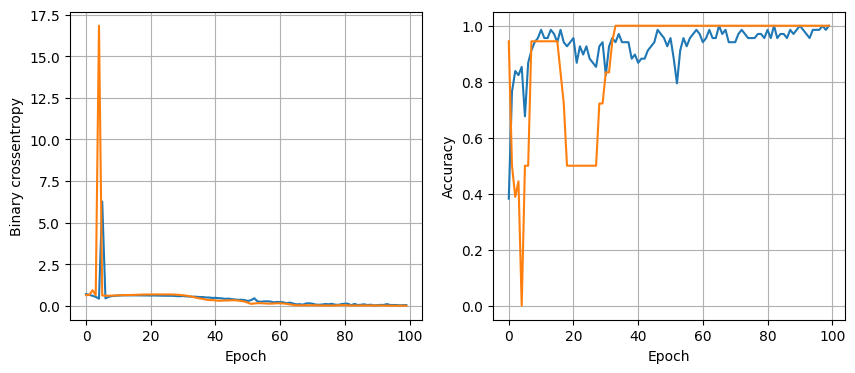

1/1 [==============================] - 0s 28ms/step - loss: 0.0014 - accuracy: 1.0000
64 nodes, dropout 0.2, lr 0.01, batch size 128


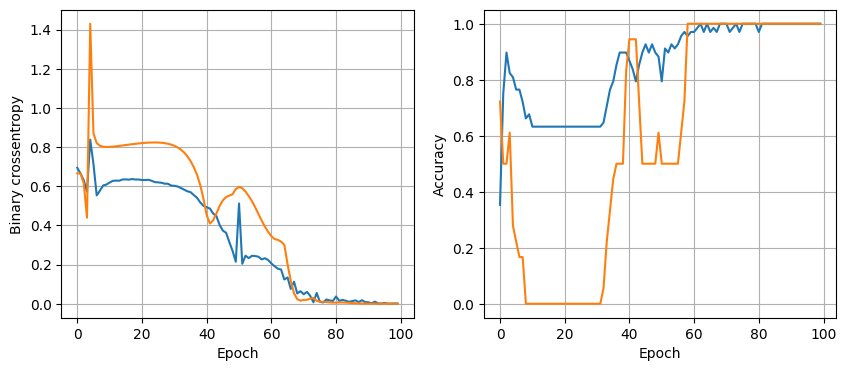

1/1 [==============================] - 0s 19ms/step - loss: 8.0663e-04 - accuracy: 1.0000
64 nodes, dropout 0.2, lr 0.005, batch size 32


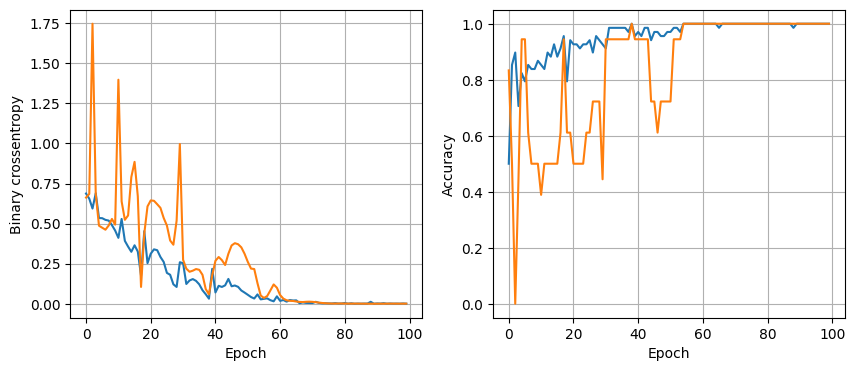

1/1 [==============================] - 0s 20ms/step - loss: 4.6310e-04 - accuracy: 1.0000
64 nodes, dropout 0.2, lr 0.005, batch size 64


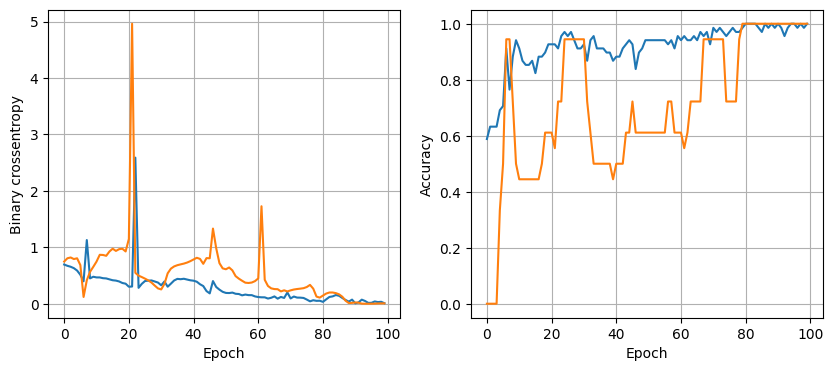

1/1 [==============================] - 0s 32ms/step - loss: 0.0070 - accuracy: 1.0000
64 nodes, dropout 0.2, lr 0.005, batch size 128


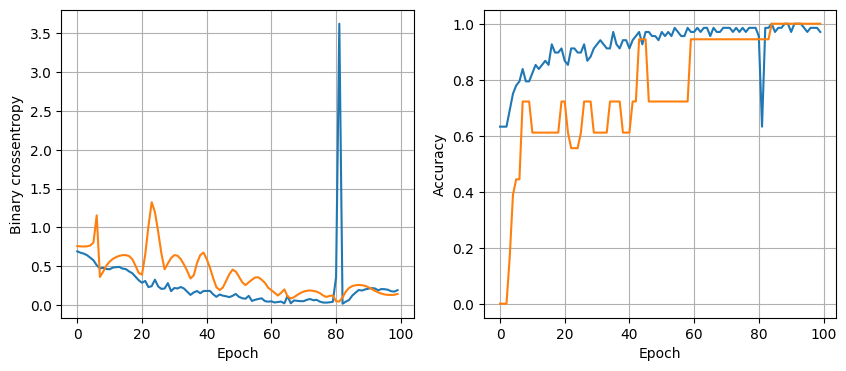

1/1 [==============================] - 0s 21ms/step - loss: 0.1339 - accuracy: 1.0000
64 nodes, dropout 0.2, lr 0.001, batch size 32


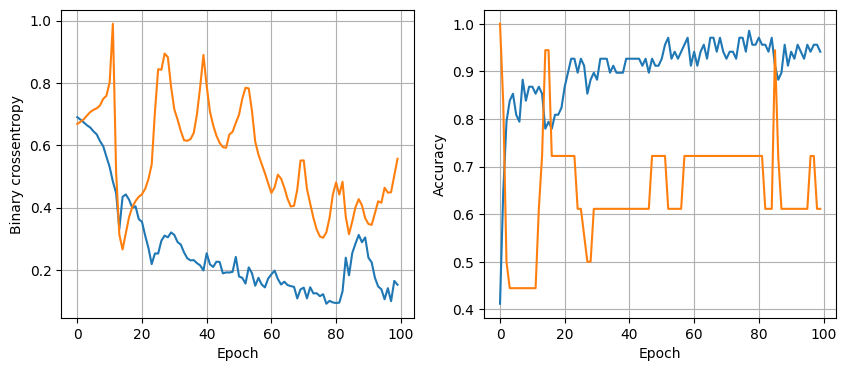

1/1 [==============================] - 0s 32ms/step - loss: 0.2616 - accuracy: 0.9500
64 nodes, dropout 0.2, lr 0.001, batch size 64


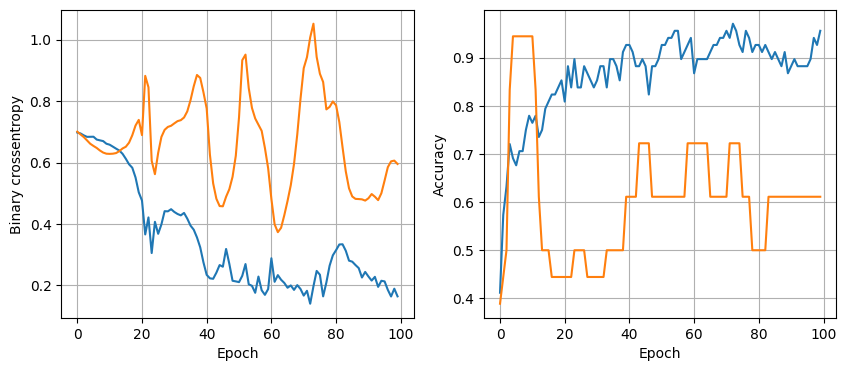

1/1 [==============================] - 0s 21ms/step - loss: 0.1889 - accuracy: 0.9500
64 nodes, dropout 0.2, lr 0.001, batch size 128


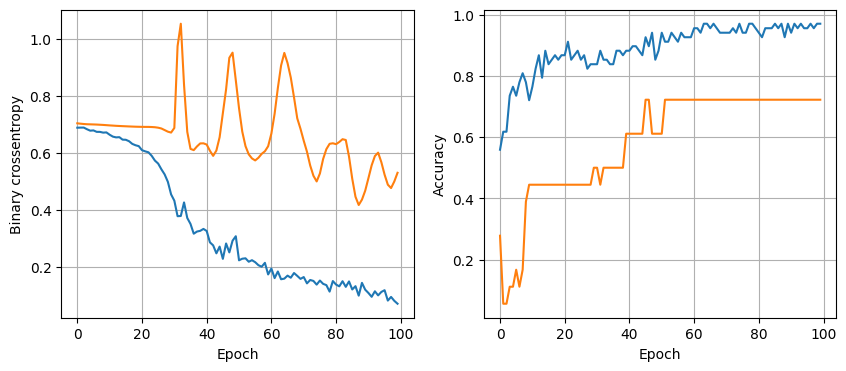

1/1 [==============================] - 0s 31ms/step - loss: 0.0522 - accuracy: 1.0000


In [ ]:
# least_val_loss = float('inf')
# least_loss_model = None
# epochs=100

# for num_filters in [32, 64]:
#     for kernel_size in [3, 5]:
#         for pool_size in [2, 4]:
#             for num_nodes in [16, 32, 64]:
#                 for dropout_prob in [0, 0.2]:
#                     for lr in [0.01, 0.005, 0.001]:
#                         for batch_size in [32, 64, 128]:
#                           print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
#                           model, history = train_dual_conv_model(X_train, y_train, num_filters, kernel_size, pool_size, num_nodes, dropout_prob, lr, batch_size, epochs)
#                           plot_history(history)
#                           val_loss = model.evaluate(X_valid, y_valid)[0]
#                           if val_loss < least_val_loss:
#                             least_val_loss = val_loss
#                             least_loss_model = model



# least_val_loss = float('inf')
# least_loss_model = None
# epochs=100
# for num_nodes in [16, 32, 64]:
#   for dropout_prob in[0, 0.2]:
#     for lr in [0.01, 0.005, 0.001]:
#       for batch_size in [32, 64, 128]:
#         print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
#         model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
#         plot_history(history)
#         val_loss = model.evaluate(X_valid, y_valid)[0]
#         if val_loss < least_val_loss:
#           least_val_loss = val_loss
#           least_loss_model = model




least_val_loss = float('inf')
least_loss_model = None
epochs = 100

for num_nodes in [16, 32, 64]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.01, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
                model, history = train_lstm_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
                plot_history(history)
                
                # Reshape validation data before evaluation
                X_valid_reshaped = X_valid[:, :, np.newaxis]
                val_loss = model.evaluate(X_valid_reshaped, y_valid)[0]
                
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model


In [ ]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)

1/1 [==============================] - 0s 342ms/step


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [ ]:


# Load the saved model
# loaded_model = load_model("speaker_verification_model.h5")
least_loss_model.save("speaker_verification_model.h5")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



array([[-1.06307015, -1.28912312, -0.1454008 , ...,  0.71300117,
        -0.62876771,  1.        ],
       [ 1.6646583 ,  1.14314944, -1.57464771, ...,  1.42194429,
         1.59041245,  0.        ],
       [-0.87251208, -0.74547606, -0.11933675, ...,  0.14929813,
        -0.62876771,  1.        ],
       ...,
       [ 1.53194905,  0.23230467,  0.60561857, ..., -1.4739716 ,
         1.59041245,  0.        ],
       [ 1.08893594,  0.6957559 ,  1.02897782, ..., -0.19312958,
         1.59041245,  0.        ],
       [ 0.92264305,  0.03303126, -0.18541822, ..., -0.70381253,
         1.59041245,  0.        ]])